In [1]:
from jax import random
from neural_tangents import stax
import pandas as pd
import jax.numpy as jnp
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import jax.nn as nn

In [7]:
import pandas as pd
import jax.numpy as jnp
from sklearn.preprocessing import StandardScaler

def permut_row(x, perm):
            return x[perm]

def load_and_prepare_csv(file_path, perm=False):
    # Step 1: Read the CSV file
    df = pd.read_csv(file_path)
    
    # Step 2: Normalize the data (if needed)
    # Assuming that all columns except the last one are features and the last one is the label
    if perm == True:
        perm = np.random.permutation(784)
        features = df.iloc[:, 1:] / 255
        features = np.apply_along_axis(permut_row, axis = 1, arr=features, perm=perm)
    else :
        features = df.iloc[:, 1:] / 255
    labels = df.iloc[:, 0]
    labels = nn.one_hot(jnp.array(labels), 10)
    
    # Normalize the features
    
    
    # Step 3: Convert to Jax arrays
    features_jax = jnp.array(features)
    labels_jax = jnp.array(labels)
    
    return features_jax, labels_jax

# Example usage
X, Y = load_and_prepare_csv('~/data/MNIST/mnist_train.csv')
X_t, Y_t = load_and_prepare_csv('~/data/MNIST/mnist_test.csv')

X_p, Y = load_and_prepare_csv('~/data/MNIST/mnist_test.csv', perm=True)

In [8]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(128), stax.Relu(),
    stax.Dense(128), stax.Relu(),
    stax.Dense(10),
)

key1, key2 = random.split(random.PRNGKey(1))

_, params = init_fn(key1, input_shape=X.shape)

ntk = kernel_fn(X[:200], None, 'ntk')

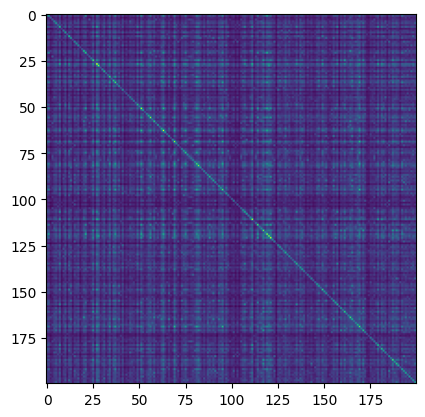

In [9]:
plt.imshow(ntk.reshape((200,200)))
plt.show()

In [5]:
import neural_tangents as nt
lim = 100

t = 1E12
# Kernel X_1,X_1
k_train_train = kernel_fn(X[:lim], None, 'ntk')

# Kernel X_2,X_1
k_test_train = kernel_fn(X_t[:lim], X[:lim], 'ntk')

k_perm_train = kernel_fn(X_p[:lim], X[:lim], 'ntk')

# Training on MSE with GD
predict_fn = nt.predict.gradient_descent_mse(k_train_train, Y[:lim])

# Make prediction on k_test_train after training for time t
y_test_ntk2 = predict_fn(t=t, k_test_train=k_perm_train)
y_test_ntk1 = predict_fn(t=t, k_test_train=k_test_train)

y_train_0 = apply_fn(params, X[:lim])
y_test_0 = apply_fn(params, X_p[:lim])

In [6]:
delta1 = np.sum(y_test_ntk1-Y[:lim], axis=1)

In [ ]:
delta2 = np.sum(y_test_ntk2 - Y[:lim], axis=1)

In [ ]:
ntk12 = kernel_fn(X[:lim], X_p[:lim], 'ntk')
ntk22 = kernel_fn(X_p[:lim], X_p[:lim], 'ntk')
ntk22_inv = np.linalg.inv(ntk22)

In [ ]:
delta_th = -delta2 @ ntk12 @ ntk22_inv

In [ ]:
k_train_train = kernel_fn(X_p[:lim], None, 'ntk')

predict_fn = nt.predict.gradient_descent_mse(k_train_train, Y[:lim])

y_test_ntk11 = predict_fn(t=t, fx_train_0=y_train_0, k_test_train=k_test_train)

In [ ]:
y_test_ntk11.shape

In [ ]:
delta11 = np.sum(y_test_ntk11 - Y[:lim], axis=1)

In [ ]:
print((delta_th-delta11)/delta11)
